# Forward Propagation
## Convolutional Layer
- Perform elementwise matrix multiplication of the local regions in the input with the kernel
- This will result in the output volume with dimension WxHxD where D is the number of kernels
## ReLU Activation Function
- Apply ReLU activation function on the output volume
- ReLU(x) = max(0,x)
## Max Pooling or Average Pooling
- Downsample the output volume into smaller matrix (tensor)
## Fully Connected Layer (FC)
### Flatten Output Matrix (Tensor)
### Define Hidden Layers
- The number of hidden layers
- Weight initialization for each node
- Activation function
### Output Vector (Softmax)
- If the output has only two lables, we use the sigmoid function
- If the output has more than two labels, we use the softmax function

# Backpropagation
## Compute Loss (Categorical Entropy)
- Define the loss function (predicted label vs actual label)
- CE = $-\sum_{i}^{C}t_i\log(f(s)_i)$ where $f(s)_i=\frac{e^{s_i}}{\sum_{j}^{C}e^{s_j}}$
## Compute Gradients
### Partial Derivative - Loss w.r.t Input (dL/dX)
### Partial Derivative - Loss w.r.t Kernel (dL/dF)
### Partial Derivative - Loss w.r.t Bias (dL/dB)

# Individual Functions Implementation

## Load Example Dataset

In [2]:
!pip install tensorflow-keras

In [3]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

(X_train, y_train), (_, _) = mnist.load_data()

In [4]:
# the train set consists of 60,000 images, each with a size of 28x28
X_train.shape

(60000, 28, 28)

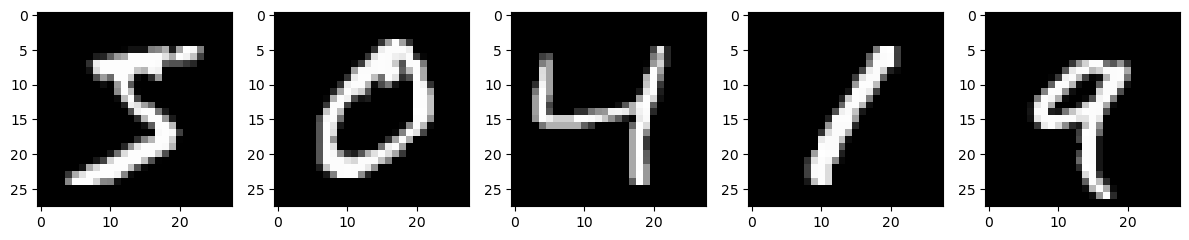

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(12,8))

axes = axes.flatten()

for i in range(5):
    axes[i].imshow(X_train[i], cmap='gray')
    
plt.tight_layout()
plt.show()

In [6]:
example_img = X_train[0]

In [7]:
example_img.shape

(28, 28)

In [8]:
example_img.size

784

## Foward Operation

Let's do a forward operation where we take the input image, pass it through the convolutional layer with different filters, perform activation ReLU and downsampling through max pooling, to flattening the output to the fully connected layer

### Test Numpy Operations

In [9]:
import numpy as np

In [10]:
# define hyperparameters
stride = 2
zero_padding = 0
num_filters = 3
filter_size = 2


In [11]:
# initalize weights for the filters
kernel1 = np.ones((filter_size, filter_size))
kernel2 = np.ones((filter_size, filter_size))

In [12]:
# check to make sure the filter has the same number of dimensions as the input image
kernel1

array([[1., 1.],
       [1., 1.]])

In [13]:
# size of output volumn
output_size = int((example_img.shape[0] - kernel1.shape[0] + 2*zero_padding)/stride + 1)
output_size
output1 = np.zeros((output_size, output_size))
output2 = np.zeros((output_size, output_size))

In [14]:
W0 = kernel1
W1 = kernel2
W0.shape

(2, 2)

In [15]:
output1[0][0] = np.sum(example_img[0:filter_size, 0:filter_size]*W0)

In [16]:
output1[0][0]

0.0

In [17]:
# now perform convolution to generate the first output for the map
for i in range(0, output_size, stride):
    for j in range(0, output_size, stride):
        if i + filter_size <= example_img.shape[0] and i + filter_size <= example_img.shape[1]:
            output1[i//stride][j//stride] = np.sum(example_img[i:i+filter_size, j:j+filter_size]*W0)

In [18]:
# now perform convolution to generate the second output for the map
for i in range(0, output_size, stride):
    for j in range(0, output_size, stride):
        if i + filter_size <= example_img.shape[0] and i + filter_size <= example_img.shape[1]:
            output2[i//stride][j//stride] = np.sum(example_img[i:i+filter_size, j:j+filter_size]*W1)

In [19]:
output1.shape

(14, 14)

In [20]:
output2.shape

(14, 14)

In [21]:
# stack two output volumes together to generate the final activation map
final_output = np.stack((output1, output2), axis=2)

In [22]:
final_output.shape

(14, 14, 2)

In [23]:
# now perform ReLU
activated_final_output = np.maximum(0, final_output)

In [24]:
activated_final_output.shape

(14, 14, 2)

In [25]:
# now perform pooling to downsample the output volumn
pooled_size = int((activated_final_output.shape[0]-2)/2 + 1)
pooled_output = np.zeros((pooled_size, pooled_size, activated_final_output.shape[2]))
pooled_output.shape

(7, 7, 2)

In [26]:
for i in range(0, pooled_size, 2):
    for j in range(0, pooled_size, 2):
        for k in range(0, 2):
            if i + 2 <= activated_final_output.shape[0] and j + 2 <= activated_final_output.shape[1]:
                pooled_output[i//2][j//2][k] = np.max(activated_final_output[i:i+pooled_size, j:j+pooled_size])

In [27]:
pooled_output.shape

(7, 7, 2)

In [28]:
# flatten the output
flattened_output = pooled_output.flatten()
flattened_output.shape

(98,)

In [29]:
np.random.uniform(0,1, (3,3)).shape

(3, 3)

### Convolution Function (With Numpy Only)

In [38]:
# putting it altogether
from typing import Optional, Any
import numpy.typing as npt

def conv_forward(input: npt.ArrayLike,
                 stride: int, 
                 filter_size: int,
                 num_filters: int,
                 zero_padding: Optional[bool],
                 pad_amount: int,
                 debug=False):
    
    # Step 1: Initialize a dictionary to store the filters named as W0, W1, etc.
    filters = {}
    input_depth = input.shape[2]
    
    for num in range(num_filters):
        filters[f"W_{num}"] = np.random.uniform(0,1,(filter_size, filter_size, input_depth))
        print(f"W_{num}: {filters[f'W_{num}'].shape}")
    
    if debug == True:
        print(f"All filters: {filters}")
        
    # Step 2: Compute the expected output volume size after convolution
    output_volume_size = int((input.shape[0] - filter_size + 2*pad_amount)/stride + 1)
    print(f"Expected output volume width and height: {output_volume_size}")
    if int(output_volume_size) != output_volume_size:
        print("Please choose different parameters because the output volume size is not an integer")
    else:
        output_matrix = np.zeros((output_volume_size, output_volume_size, len(filters))) # initialize the output matrix with the expected dimension
        print(f"Expected dimension of the output volume (WxHxD (number of filters)): {output_matrix.shape}")
            
    # Step 3: Add zero padding
    if zero_padding == True:
        padded_shape = (input.shape[0] + 2*pad_amount, input.shape[1] + 2*pad_amount, input.shape[2])
        input_padded = np.zeros(padded_shape)
        for d in range(input.shape[2]):
            input_padded[:, :, d] = np.pad(input[:, :, d], pad_amount)
        print(f"Padded input with 1-zero padding: {input_padded.shape}")
    else:
        input_padded = input
        
    # Step 4: Compute activation map by performing convolution
    activation_maps = np.zeros((output_volume_size, output_volume_size, num_filters))
    
    for num in range(len(filters)): # loop through each filter       
        for i in range(0, output_volume_size, stride): # row dimension
            for j in range(0, output_volume_size, stride): # column dimension
                if i + stride <= output_volume_size and j + stride <= output_volume_size:
                    # Extract the region of interest from the input
                    region = input_padded[i*stride:i*stride+filter_size, j*stride:j*stride+filter_size, :] # slice to get all the slice along the depth axis 
                    # Perform convolution (element-wise multiplication and sum)
                    activation_maps[i, j, num] = np.sum(region * filters[f"W_{num}"])
    
        print(f"Activation map for filter {num}: {activation_maps[:, :, num].shape}")
    return activation_maps

In [39]:
# test a simple case
input = np.zeros((5,5,2))
input += np.random.randint(1, 25, size=input.shape)
input.shape

(5, 5, 2)

In [45]:
input

array([[[ 3., 12.],
        [ 3., 24.],
        [ 8., 10.],
        [11.,  5.],
        [23., 19.]],

       [[ 3.,  6.],
        [16.,  1.],
        [20., 21.],
        [21., 19.],
        [ 3., 17.]],

       [[ 2., 12.],
        [ 4., 10.],
        [22., 23.],
        [14.,  7.],
        [16., 23.]],

       [[13.,  6.],
        [ 3., 16.],
        [ 5., 22.],
        [ 8., 10.],
        [24., 21.]],

       [[19., 14.],
        [20.,  4.],
        [10., 10.],
        [18., 21.],
        [14.,  7.]]])

In [40]:
stride = 2
filter_size = 3
num_filters = 2
zero_padding = True
pad_amount = 1
debug=False

output_volume = conv_forward(input, stride, filter_size, num_filters, zero_padding, pad_amount, debug)

W_0: (3, 3, 2)
W_1: (3, 3, 2)
Expected output volume width and height: 3
Expected dimension of the output volume (WxHxD (number of filters)): (3, 3, 2)
Padded input with 1-zero padding: (7, 7, 2)
Activation map for filter 0: (3, 3)
Activation map for filter 1: (3, 3)


In [44]:
output_volume.shape

(3, 3, 2)

### ReLU Function

In [46]:
def relu_forward(output_volume):
    activated_output = output_volume
    for k in range(output_volume.shape[-1]):  # Loop over each channel (depth)
        for i in range(0, output_volume.shape[0]):  # Loop over rows
            for j in range(0, output_volume.shape[1]):  # Loop over columns
                # Extract the region of interest for the current channel
                activated_output[i,j,k] = np.max(output_volume[i,j,k])
    return activated_output

In [49]:
relu_output = relu_forward(output_volume)

### Max Pooling Function

In [48]:
def max_pooling_forward(output_volume, stride, kernel_size):
    # Calculate the output size
    output_size = int((output_volume.shape[0] - kernel_size) / stride + 1)
    output_size = int(output_size)  # Ensure it's an integer
    
    # Initialize the output array
    max_pooled_output = np.zeros((output_size, output_size, output_volume.shape[-1]))
    
    # Perform max pooling
    for k in range(output_volume.shape[-1]):  # Loop over each channel (depth)
        for i in range(0, output_size):  # Loop over rows
            for j in range(0, output_size):  # Loop over columns
                # Extract the region of interest for the current channel
                region = output_volume[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, k]
                # Compute the maximum value in the region
                max_pooled_output[i, j, k] = np.max(region)
    
    return max_pooled_output

In [54]:
max_pooled_output = max_pooling_forward(relu_output, 1, 2)

In [55]:
max_pooled_output.shape

(2, 2, 2)

### Fully Connected Layer

In [61]:
def relu(Z):
    return np.maximum(0, Z)

In [62]:
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / expZ.sum(axis=0, keepdims=True)

In [63]:
def fc_layer(input, num_hidden_layers=2, hidden_size=10, output_size=3):
    # Step 1: Flatten the output (the result of the max pooling layer)
    input = input.flatten()
    
    # Step 2: Initialize weights the hidden layer(s)
    W0 = np.random.rand(len(input), hidden_size)
    W1 = np.random.rand(hidden_size, output_size)
    
    # Step 3: Compute the dot product between the input and the weight vector & apply the activation function
    Z1 = np.dot(input, W0)
    A1 = relu(Z1)
    Z2 = np.dot(A1, W1)
    A2 = softmax(Z2)
    
    return A2

In [65]:
predictions = fc_layer(max_pooled_output)

In [66]:
predictions.shape

(3,)

In [67]:
predictions

array([3.05206324e-04, 7.32799542e-09, 9.99694786e-01])

# OOP Implementation

In [68]:
import numpy as np
from typing import Optional, Union, List, Tuple
import numpy.typing as npt
import matplotlib.pyplot as plt

# Use the CNN class from the previous implementation
class CNN:
    def __init__(self, 
                 input: npt.ArrayLike,
                 stride: int, 
                 filter_size: int,
                 kernel_size: int,
                 num_filters: int,
                 zero_padding: Optional[bool],
                 pad_amount: int,
                 num_hidden_layers: int,
                 learning_rate: float = 0.01,
                 debug=False):
        self.input = input
        self.stride = stride
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.zero_padding = zero_padding
        self.pad_amount = pad_amount
        self.num_hidden_layers = num_hidden_layers
        self.learning_rate = learning_rate
        self.debug = debug
        
        # Store parameters and activations for backpropagation
        self.filters = {}
        self.W0 = None  # FC layer weights
        self.W1 = None  # Output layer weights
        self.conv_output = None
        self.activated_output = None
        self.pooled_output = None
        self.flattened_input = None
        self.Z1 = None
        self.A1 = None
        self.Z2 = None
        self.A2 = None  # Final output
    
    def conv_forward(self):
        # Step 1: Initialize a dictionary to store the filters named as W0, W1, etc.
        self.filters = {}
        input_depth = self.input.shape[2]
        
        for num in range(self.num_filters):
            self.filters[f"W_{num}"] = np.random.uniform(-0.1, 0.1, (self.filter_size, self.filter_size, input_depth)) # randomly intialize the weight for the filters
        if self.debug == True:
            print(f"All filters initialized with shape: {self.filters['W_0'].shape}")
            
        # Step 2: Compute the expected output volume size after convolution
        output_volume_size = int((self.input.shape[0] - self.filter_size + 2*self.pad_amount)/self.stride + 1)
        if int(output_volume_size) != output_volume_size:
            print("Please choose different kernel size, stride or zero padding because the output volume size is not an integer")
            return None
        else:
            output_matrix = np.zeros((output_volume_size, output_volume_size, len(self.filters))) # initialize the output matrix with the expected dimension
            if self.debug:
                print(f"Expected dimension of the output volume (WxHxD): {output_matrix.shape}")
                
        # Step 3: Add zero padding
        if self.zero_padding == True:
            padded_shape = (self.input.shape[0] + 2*self.pad_amount, self.input.shape[1] + 2*self.pad_amount, self.input.shape[2]) # only add padding to the row and column dimension, not the depth dimension
            input_padded = np.zeros(padded_shape)
            for d in range(self.input.shape[2]):
                input_padded[:, :, d] = np.pad(self.input[:, :, d], self.pad_amount)
        else:
            input_padded = self.input
            
        # Step 4: Compute activation map by performing convolution
        output_volume = np.zeros((output_volume_size, output_volume_size, self.num_filters))
        self.input_padded = input_padded  # Store for backpropagation
        self.regions = {}  # Store regions for backpropagation
        
        for num in range(len(self.filters)): # loop through each filter       
            for i in range(output_volume_size): # row dimension
                for j in range(output_volume_size): # column dimension
                    # Extract the region of interest from the input
                    start_i = i * self.stride
                    start_j = j * self.stride
                    end_i = start_i + self.filter_size
                    end_j = start_j + self.filter_size
                    
                    # Ensure we're within bounds
                    if end_i <= input_padded.shape[0] and end_j <= input_padded.shape[1]:
                        region = input_padded[start_i:end_i, start_j:end_j, :] # slice to get all the slice along the depth axis 
                        # Store region for backpropagation
                        self.regions[(i, j, num)] = (start_i, start_j, end_i, end_j)
                        # Perform convolution (element-wise multiplication and sum the products to get the cell in the output volume)
                        output_volume[i, j, num] = np.sum(region * self.filters[f"W_{num}"])
        
        return output_volume
    
    def relu_conv(self, output_volume):
        # Vectorized implementation for efficiency
        return np.maximum(0, output_volume)
    
    def max_pool(self, activated_output):
        # Calculate the output size
        output_size = int((activated_output.shape[0] - self.kernel_size) / self.stride + 1)
        output_size = int(output_size)  # Ensure it's an integer
        
        # Initialize the output array
        max_pooled_output = np.zeros((output_size, output_size, activated_output.shape[-1]))
        # Store max positions for backpropagation
        self.pool_indices = {}
        
        # Perform max pooling
        for k in range(activated_output.shape[-1]):  # Loop over each channel (depth)
            for i in range(output_size):  # Loop over rows
                for j in range(output_size):  # Loop over columns
                    # Extract the region of interest for the current channel
                    start_i = i * self.stride
                    start_j = j * self.stride
                    end_i = start_i + self.kernel_size
                    end_j = start_j + self.kernel_size
                    region = activated_output[start_i:end_i, start_j:end_j, k]
                    
                    # Compute the maximum value in the region
                    max_val = np.max(region)
                    max_pooled_output[i, j, k] = max_val
                    
                    # Find the position of the maximum value in the region
                    # Store as (row_offset, col_offset) relative to start position
                    max_pos = np.unravel_index(np.argmax(region), region.shape)
                    self.pool_indices[(i, j, k)] = (start_i + max_pos[0], start_j + max_pos[1])
        
        return max_pooled_output
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / expZ.sum(axis=1, keepdims=True)
    
    def relu(self, Z):
        return np.maximum(0, Z)
        
    def fc(self, pooled_output, hidden_size, output_size):
        # Step 1: Flatten the output (the result of the max pooling layer)
        self.flattened_input = pooled_output.flatten()
        
        # Step 2: Initialize weights for the hidden layer(s) if not already initialized
        if self.W0 is None or self.W1 is None:
            self.W0 = np.random.randn(len(self.flattened_input), hidden_size) * 0.01
            self.W1 = np.random.randn(hidden_size, output_size) * 0.01
        
        # Step 3: Compute the dot product between the input and the weight vector & apply the activation function
        self.Z1 = np.dot(self.flattened_input, self.W0)
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W1)
        self.A2 = self.softmax(self.Z2.reshape(1, -1)).flatten()
        
        return self.A2
    
    def forward(self, hidden_size=128, output_size=10):
        """
        Complete forward pass through the CNN.
        
        Args:
            hidden_size: Size of the hidden layer
            output_size: Number of output classes
            
        Returns:
            Class probabilities
        """
        # Convolution
        self.conv_output = self.conv_forward()
        if self.conv_output is None:
            return None
        
        # Activation
        self.activated_output = self.relu_conv(self.conv_output)
        
        # Pooling
        self.pooled_output = self.max_pool(self.activated_output)
        
        # Fully connected layers
        output = self.fc(self.pooled_output, hidden_size, output_size)
        
        return output
        
    def cross_entropy_loss(self, y_true):
        """
        Calculate cross-entropy loss
        
        Args:
            y_true: True label index (not one-hot encoded)
            
        Returns:
            loss: Cross-entropy loss value
        """
        return -np.log(self.A2[y_true] + 1e-15)  # Added small epsilon to avoid log(0)
        
    def backprop(self, X, y, hidden_size=128, output_size=10):
        """
        Perform backpropagation and update weights
        
        Args:
            X: Input data
            y: True label index (not one-hot encoded)
            hidden_size: Size of hidden layer
            output_size: Number of output classes
            
        Returns:
            loss: Loss value after this iteration
        """
        # Forward pass
        self.input = X
        output = self.forward(hidden_size, output_size)
        if output is None:
            return None
            
        # Compute loss
        loss = self.cross_entropy_loss(y)
        
        # Backpropagation for output layer
        dA2 = self.A2.copy()
        dA2[y] -= 1  # derivative of softmax with cross-entropy
        
        # Backpropagation through fully connected layers
        dW1 = np.outer(self.A1, dA2)
        dA1 = np.dot(dA2, self.W1.T)
        dZ1 = dA1.copy()
        dZ1[self.Z1 <= 0] = 0  # derivative of ReLU
        dW0 = np.outer(self.flattened_input, dZ1)
        
        # Backpropagation through pooling layer
        dpool = np.zeros_like(self.activated_output)
        dflat = np.dot(dZ1, self.W0.T)
        dpool_reshaped = dflat.reshape(self.pooled_output.shape)
        
        # Distribute gradients through max pooling layer
        for k in range(self.pooled_output.shape[2]):
            for i in range(self.pooled_output.shape[0]):
                for j in range(self.pooled_output.shape[1]):
                    if (i, j, k) in self.pool_indices:
                        max_i, max_j = self.pool_indices[(i, j, k)]
                        dpool[max_i, max_j, k] += dpool_reshaped[i, j, k]
                    
        # Backpropagation through ReLU
        drelu = dpool.copy()
        drelu[self.activated_output <= 0] = 0
        
        # Backpropagation through convolutional layer
        dfilters = {f"W_{i}": np.zeros_like(self.filters[f"W_{i}"]) for i in range(self.num_filters)}
        
        for num in range(self.num_filters):
            for i in range(self.conv_output.shape[0]):
                for j in range(self.conv_output.shape[1]):
                    if (i, j, num) in self.regions:
                        start_i, start_j, end_i, end_j = self.regions[(i, j, num)]
                        region = self.input_padded[start_i:end_i, start_j:end_j, :]
                        dfilters[f"W_{num}"] += region * drelu[i, j, num]
        
        # Update weights
        for num in range(self.num_filters):
            self.filters[f"W_{num}"] -= self.learning_rate * dfilters[f"W_{num}"]
        
        self.W1 -= self.learning_rate * dW1
        self.W0 -= self.learning_rate * dW0
        
        return loss
    
    def train(self, X_train, y_train, epochs=5, batch_size=1, hidden_size=64, output_size=10):
        """
        Train the CNN using mini-batch gradient descent
        
        Args:
            X_train: Training data
            y_train: Training labels
            epochs: Number of training epochs
            batch_size: Mini-batch size
            hidden_size: Size of hidden layer
            output_size: Number of output classes
            
        Returns:
            losses: List of loss values for each epoch
        """
        num_samples = X_train.shape[0]
        losses = []
        
        for epoch in range(epochs):
            epoch_loss = 0
            
            for i in range(num_samples):
                X = X_train[i]
                y = y_train[i]
                
                # Update weights using backpropagation
                batch_loss = self.backprop(X, y, hidden_size, output_size)
                if batch_loss is not None:
                    epoch_loss += batch_loss
            
            # Calculate average loss for the epoch
            avg_loss = epoch_loss / num_samples
            losses.append(avg_loss)
            
            if self.debug:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
                
            # Test on a random sample after each epoch
            if self.debug and epoch % 1 == 0:
                test_idx = np.random.randint(0, num_samples)
                test_img = X_train[test_idx]
                test_label = y_train[test_idx]
                
                self.input = test_img
                pred = self.forward(hidden_size, output_size)
                pred_label = np.argmax(pred)
                
                print(f"Test sample: True label={test_label}, Predicted={pred_label}")
        
        return losses


In [71]:
def preprocess_mnist_for_cnn(X, y, num_samples=100):
    """
    Prepare MNIST data for CNN processing
    
    Args:
        X: MNIST images (60000, 28, 28)
        y: MNIST labels (60000,)
        num_samples: Number of samples to use (for testing)
        
    Returns:
        X_processed: Processed images for CNN with channel dimension
        y_processed: Processed labels
    """
    # Take a subset for testing
    X_subset = X[:num_samples]
    y_subset = y[:num_samples]
    
    # Reshape to add channel dimension for CNN [samples, height, width, channels]
    X_processed = X_subset.reshape(-1, 28, 28, 1)
    
    # Normalize pixel values to [0, 1]
    X_processed = X_processed.astype('float32') / 255.0
    
    return X_processed, y_subset

def test_cnn_with_mnist(X_train, y_train, num_samples=100):
    X_processed, y_processed = preprocess_mnist_for_cnn(X_train, y_train, num_samples)
    
    cnn = CNN(
        input=X_processed[0],
        stride=1,
        filter_size=3,
        kernel_size=2,
        num_filters=8,
        zero_padding=True,
        pad_amount=1,
        num_hidden_layers=1,
        learning_rate=0.01,
        debug=True
    )
    
    # Train on the small subset
    print(f"Training CNN on {num_samples} MNIST samples...")
    losses = cnn.train(
        X_train=X_processed,
        y_train=y_processed,
        epochs=3,
        batch_size=1,
        hidden_size=32,
        output_size=10
    )
    
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    # Test and visualize some predictions
    num_test = min(5, num_samples)
    fig, axes = plt.subplots(1, num_test, figsize=(15, 3))
    
    for i in range(num_test):
        # Make prediction
        cnn.input = X_processed[i]
        pred = cnn.forward(hidden_size=32, output_size=10)
        pred_label = np.argmax(pred)
        
        # Display image and prediction
        axes[i].imshow(X_processed[i].reshape(28, 28), cmap='gray')
        if pred_label == y_processed[i]:
            color = 'green'
        else:
            color = 'red'
        axes[i].set_title(f'Pred: {pred_label}\nTrue: {y_processed[i]}', color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return cnn, losses

def run_mnist_test(X_train, y_train, num_samples=100):
    cnn, losses = test_cnn_with_mnist(X_train, y_train, num_samples)
    print("Test completed!")
    return cnn

Training CNN on 100 MNIST samples...
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)


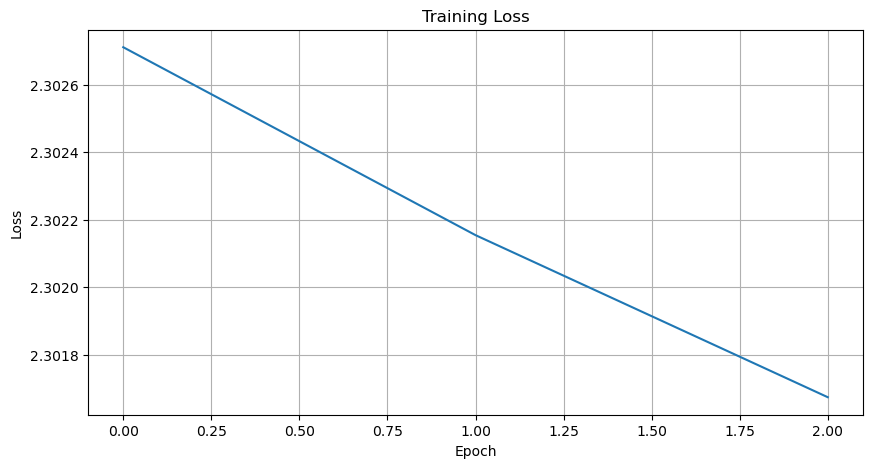

All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)
All filters initialized with shape: (3, 3, 1)
Expected dimension of the output volume (WxHxD): (28, 28, 8)


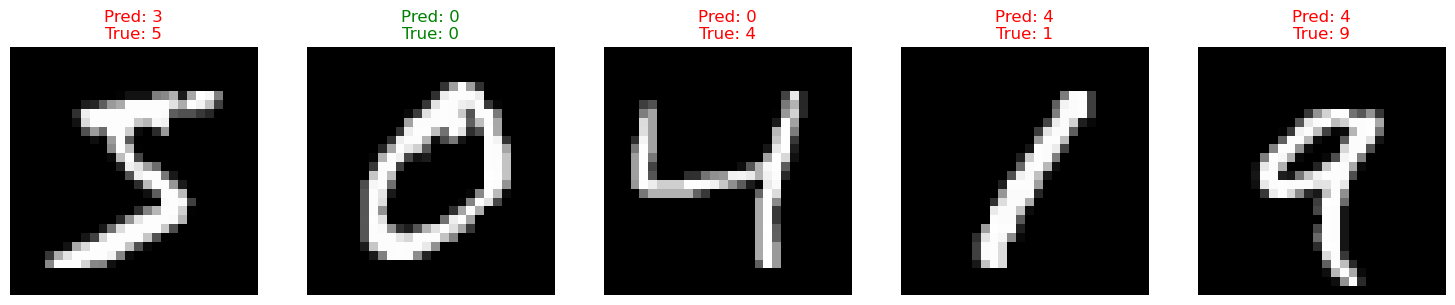

Test completed!


In [70]:
# Run with a small subset for quick testing
num_samples_to_test = 100
cnn_model = run_mnist_test(X_train, y_train, num_samples=num_samples_to_test)

# References
1. https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/?source=post_page-----46026a8f5d2c---------------------------------------
2. https://www.youtube.com/watch?v=lZrIPRnoGQQ
3. chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/lectures/lecture5.pdf